In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
#Other necessary imports
import matplotlib.pyplot as plt

from PIL import Image
import keras
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Defining a results visualization function
def visualize_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    #Instantiate values
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']
    train_recall = history.history['recall']
    train_aucroc = history.history['auc']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    val_recall = history.history['val_recall']
    val_aucroc = history.history['val_auc']
    
    #Create figure for plotting
    fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Results')
    #plt.xlabel('Epoch')
    
    #Plot Loss
    ax1.plot(train_loss)
    ax1.plot(val_loss)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epochs')
    ax1.legend(['train', 'val'])
    
    #Plot Accuracy
    ax2.plot(train_acc)
    ax2.plot(val_acc)
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.legend(['train', 'val'])
    
    #Plot Recall
    ax3.plot(train_recall)
    ax3.plot(val_recall)
    ax3.set_ylabel('Recall')
    ax3.set_xlabel('Epochs')
    ax3.legend(['train', 'val'])
    
    #Plot AUC-ROC
    ax4.plot(train_aucroc)
    ax4.plot(val_aucroc)
    ax4.set_ylabel('AUC-ROC')
    ax4.set_xlabel('Epochs')
    ax4.legend(['train', 'val'])
    
    plt.show();

# Load Preprocessed Data

In [4]:
#Load data
train_images = np.load('../input/eda-and-data-preprocessing/train_images.npy')
train_labels = np.load('../input/eda-and-data-preprocessing/train_labels.npy')

train_images_third = np.load('../input/eda-and-data-preprocessing/train_images_third.npy')
train_labels_third = np.load('../input/eda-and-data-preprocessing/train_labels_third.npy')

val_images = np.load('../input/eda-and-data-preprocessing/val_images.npy')
val_labels = np.load('../input/eda-and-data-preprocessing/val_labels.npy')

test_images = np.load('../input/eda-and-data-preprocessing/test_images.npy')
test_labels = np.load('../input/eda-and-data-preprocessing/test_labels.npy')

In [5]:
#Explore the dataset again
print ("Number of training samples: " + str(train_images.shape[0]))
print ("A third of training samples: " + str(train_images_third.shape[0]))
print ("Number of validation samples: " + str(val_images.shape[0]))
print ("Number of testing samples: " + str(test_images.shape[0]))
print ("===")
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("A third of train_images shape: " + str(train_images_third.shape))
print ("A third of train_labels shape: " + str(train_labels_third.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 25803
A third of training samples: 8601
Number of validation samples: 8602
Number of testing samples: 3823
===
train_images shape: (25803, 128, 128, 3)
train_labels shape: (25803,)
A third of train_images shape: (8601, 128, 128, 3)
A third of train_labels shape: (8601,)
val_images shape: (8602, 128, 128, 3)
val_labels shape: (8602,)
test_images shape: (3823, 128, 128, 3)
test_labels shape: (3823,)


# Modeling

In [6]:
#Build my first CNN model
first_cnn_model = models.Sequential()
first_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128,  3)))
first_cnn_model.add(layers.MaxPooling2D((2, 2)))

first_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
first_cnn_model.add(layers.MaxPooling2D((2, 2)))

first_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
first_cnn_model.add(layers.MaxPooling2D((2, 2)))

first_cnn_model.add(layers.Flatten())
first_cnn_model.add(layers.Dense(64, activation='relu'))
first_cnn_model.add(layers.Dense(1, activation='sigmoid'))

2021-11-30 00:42:34.900204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 00:42:35.033218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 00:42:35.033957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 00:42:35.035606: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
#Get the summary of the model
first_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [8]:
#Compile first cnn model
first_cnn_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'Recall', 'AUC'])

#Instantiate an EarlyStopping Object
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
mc = ModelCheckpoint('best_cnn_model.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

#And fit the cnn model to the training images, validating on the val images
results = first_cnn_model.fit(train_images_third,
                            train_labels_third,
                            epochs=50,
                            batch_size=32,
                            callbacks = [es,mc],
                            validation_data=(val_images, val_labels))

2021-11-30 00:42:39.734190: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691025408 exceeds 10% of free system memory.
2021-11-30 00:42:41.515356: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691025408 exceeds 10% of free system memory.
2021-11-30 00:42:42.810315: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-30 00:42:44.924756: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


269/269 [==============================] - ETA: 0s - loss: 0.2867 - accuracy: 0.8971 - recall: 0.3444 - auc: 0.8408

2021-11-30 00:42:55.669522: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691222016 exceeds 10% of free system memory.
2021-11-30 00:42:57.441588: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691222016 exceeds 10% of free system memory.


269/269 [==============================] - 18s 39ms/step - loss: 0.2867 - accuracy: 0.8971 - recall: 0.3444 - auc: 0.8408 - val_loss: 0.2531 - val_accuracy: 0.9122 - val_recall: 0.4378 - val_auc: 0.9105

Epoch 00001: val_recall improved from -inf to 0.43784, saving model to best_cnn_model.h5
Epoch 2/50
269/269 [==============================] - 4s 17ms/step - loss: 0.2185 - accuracy: 0.9212 - recall: 0.5521 - auc: 0.9078 - val_loss: 0.2187 - val_accuracy: 0.9257 - val_recall: 0.6192 - val_auc: 0.9267

Epoch 00002: val_recall improved from 0.43784 to 0.61923, saving model to best_cnn_model.h5
Epoch 3/50
269/269 [==============================] - 5s 17ms/step - loss: 0.2043 - accuracy: 0.9254 - recall: 0.5950 - auc: 0.9222 - val_loss: 0.1979 - val_accuracy: 0.9259 - val_recall: 0.6224 - val_auc: 0.9310

Epoch 00003: val_recall improved from 0.61923 to 0.62236, saving model to best_cnn_model.h5
Epoch 4/50
269/269 [==============================] - 4s 17ms/step - loss: 0.1999 - accuracy: 0

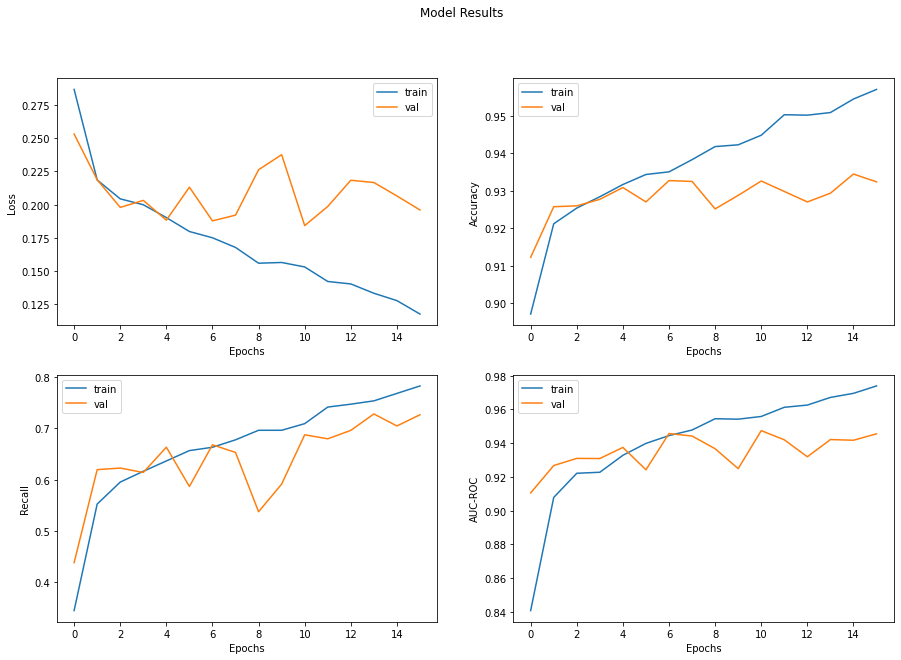

In [9]:
#Visualize Results 
visualize_results(results)

In [10]:
#Save Weights
first_cnn_model.save_weights('cnn_model_weights.h5')